In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
train_dataset = MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('data', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

In [3]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_dev_size = len(dev_dataset)

classes = 10
input_dim = 784

num_clients = 8
rounds = 5 #30
batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

total_train_size, total_dev_size, total_test_size

(49800, 10200, 10000)

In [4]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

Define Model class

In [5]:
import copy
class FederatedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}

    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out

    def get_track_layers(self):
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']

    def get_parameters(self, deep_copy = True):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data,
                'bias': self.track_layers[layer_name].bias.data
            }
        if deep_copy:
            params_clone = copy.deepcopy(parameters_dict)
            return params_clone
        else:
            return parameters_dict

    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

Define Client class

In [6]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset

    def get_dataset_size(self):
        return len(self.dataset)

    def get_client_id(self):
        return self.client_id
    
    def __difference(self, params1 : dict, params2 : dict):
        diff = {}
        for layer in params1.keys():
            diff[layer] = {}
            for key in params1[layer].keys():
                diff[layer][key] = params1[layer][key] - params2[layer][key]
        return diff

    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        wt = net.get_parameters(deep_copy=True)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        wt_plus_1 = net.get_parameters(deep_copy=True)
        update = self.__difference(wt, wt_plus_1)
        return update

Setup clients

In [7]:
def diff_l2_norm(wt, wt_plus_1):
    total_diff = 0
    for layer in wt.keys():
        for key in wt[layer].keys():
            diff = wt[layer][key] - wt_plus_1[layer][key]
            total_diff += torch.sum(diff ** 2)
    l2_norm = torch.sqrt(total_diff)
    return l2_norm

In [8]:
def reconstruct_wt_plus_1(global_params, client_updates):
    wt_plus_1 = {}
    for layer in global_params.keys():
        wt_plus_1[layer] = {}
        for key in global_params[layer].keys():
            wt_plus_1[layer][key] = global_params[layer][key] - client_updates[layer][key]
    return wt_plus_1

In [9]:
import numpy as np
def flatten_dict_to_vector(d):
    flat_list = []
    shapes = {}
    
    for k1, v1 in d.items():
        for k2, tensor in v1.items():
            shapes[f'{k1}_{k2}'] = tensor.shape
            flat_list.extend(tensor.flatten().numpy())
    
    flat_vector = np.array(flat_list)
    return flat_vector, shapes

In [10]:
def restore_vector_to_dict(flat_vector, shapes):
    restored_dict = {}
    offset = 0
    
    for k, shape in shapes.items():
        size = np.prod(shape)
        tensor_flat = flat_vector[offset:offset + size]
        tensor = torch.tensor(tensor_flat).reshape(shape)
        
        k1, k2 = k.split('_')
        if k1 not in restored_dict:
            restored_dict[k1] = {}
        restored_dict[k1][k2] = tensor
        
        offset += size
    
    return restored_dict

Start server

In [11]:
examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client,
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [12]:
from time import time 
errors = []
start = time()
global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    updates = []
    
    # get client updates
    for client in clients:
        update = client.train(curr_parameters)
        updates.append(update)
    processed_updates = []
    
    # apply ga to updates
    for update in updates:
        flat_vector, shapes = flatten_dict_to_vector(update)
        d = flat_vector.size
        q = 5
        random_seed = 42

        np.random.seed(random_seed)
        G_np = np.random.normal(0, 1, size=(d, int(q)))
        G = torch.tensor(G_np, dtype=torch.float32)
        w = torch.matmul(G.T, torch.tensor(flat_vector)) / q
        delta = torch.matmul(G, w)
        restored_wt = restore_vector_to_dict(flat_vector, shapes)
        processed_updates.append(restored_wt)
    
    # send updates to the server
    for i, update in enumerate(processed_updates):
        errors.append(diff_l2_norm(updates[i], update))
        client_parameters = reconstruct_wt_plus_1(curr_parameters, update)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * (client_parameters[layer_name]['weight'] + curr_parameters[layer_name]['weight'])
            new_parameters[layer_name]['bias'] += fraction * (client_parameters[layer_name]['bias'] + curr_parameters[layer_name]['bias'])
    global_net.apply_parameters(new_parameters)

    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4),
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss, dev_acc))

Start Round 1 ...
client_0: Loss = 0.4903, Accuracy = 0.8524
client_1: Loss = 0.4863, Accuracy = 0.8504
client_2: Loss = 0.4877, Accuracy = 0.8478
client_3: Loss = 0.499, Accuracy = 0.8421
client_4: Loss = 0.4842, Accuracy = 0.8525
client_5: Loss = 0.497, Accuracy = 0.8458
client_6: Loss = 0.4725, Accuracy = 0.8586
client_7: Loss = 0.4901, Accuracy = 0.8533
After round 8, train_loss = 0.435, dev_loss = 0.4466, dev_acc = 0.8732

Start Round 2 ...
client_0: Loss = 0.2617, Accuracy = 0.9231
client_1: Loss = 0.2571, Accuracy = 0.9267
client_2: Loss = 0.2573, Accuracy = 0.9249
client_3: Loss = 0.2559, Accuracy = 0.9264
client_4: Loss = 0.2585, Accuracy = 0.9233
client_5: Loss = 0.266, Accuracy = 0.9215
client_6: Loss = 0.2521, Accuracy = 0.9281
client_7: Loss = 0.2532, Accuracy = 0.9253
After round 8, train_loss = 1.5813, dev_loss = 1.6377, dev_acc = 0.9066

Start Round 3 ...
client_0: Loss = 0.1648, Accuracy = 0.9506
client_1: Loss = 0.1668, Accuracy = 0.952
client_2: Loss = 0.1707, Accura

In [13]:
print('time took:', time() - start)

time took: 1549.691554069519


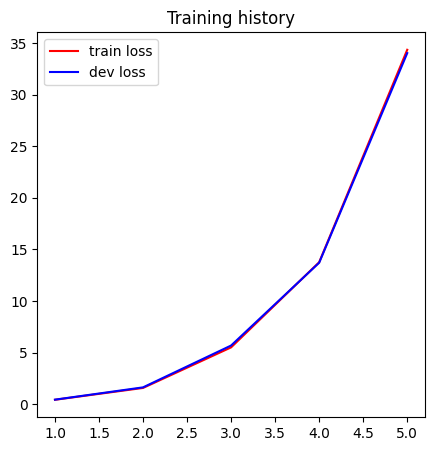

In [14]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()

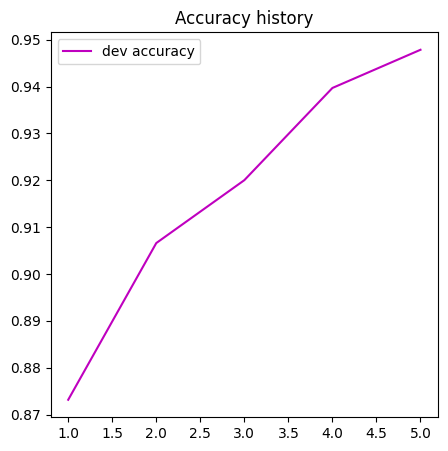

In [15]:
dev_accs = [history[i][2] for i in range(len(history))]
# Plot accuracies
plt.plot([i + 1 for i in range(len(history))], dev_accs, color='m', label='dev accuracy')
plt.legend()
plt.title('Accuracy history')
plt.show()

In [16]:
dev_accs

[0.8731711506843567,
 0.9066140055656433,
 0.9200372695922852,
 0.9397106170654297,
 0.9478604197502136]